In [3]:
import os
import random

import torch
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt
import matplotlib.markers as mks
matplotlib.rcParams["svg.fonttype"] = "none"
matplotlib.rcParams["font.family"] = "Arial"
from scipy.stats import mannwhitneyu

from src.analysis import mechanisms

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
root = os.path.expanduser("~/PycharmProjects/SpikeToExcite")
data_root = "/home/datasets/natural"  # Set the path of the natural dataset
model_id = "prediction_0.0017782794100389228_0.3_0.1_0_17_0.2_0.5"

## Firing rates and seizure prevalence

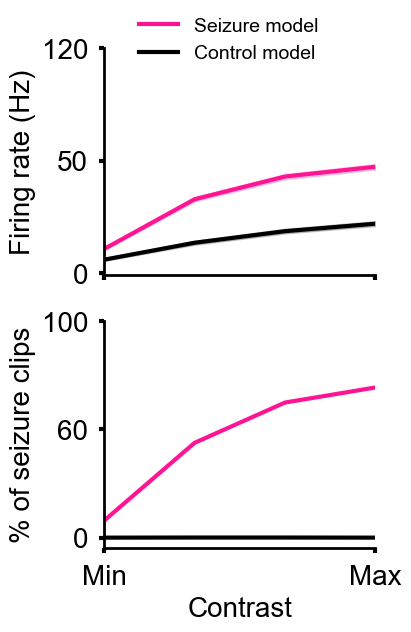

In [5]:
def plot(y_lim, x_lim, x_label, y_label, ax):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_linewidth(2)
    ax.spines["left"].set_linewidth(2)
    fs = 20
    ax.xaxis.set_tick_params(width=3, labelsize=fs, pad=8)
    ax.yaxis.set_tick_params(width=3, labelsize=fs, pad=8)
    ax.set_ylim(y_lim)
    ax.set_xlim(x_lim)
    ax.set_xlabel(x_label, fontsize=fs, labelpad=4)
    ax.set_ylabel(y_label, fontsize=fs, labelpad=4)
    
def plot_fr_vs_contrast(ax):
    plot(y_lim=(-0.01, 1), x_lim=(1, 4), x_label="Contrast", y_label="Firing rate (Hz)", ax=ax)
    sns.lineplot(fr_vs_contrast.fr_vs_contrast_df, x="contrast", y="fr", hue="model", palette=["deeppink", "black"], linewidth=3, ax=ax)
    ax.set_xticks([1, 4])
    ax.set_yticks([0, 0.5, 1])
    ax.set_yticklabels(["0", "50", "120"])

def plot_sr_vs_contrast(ax):
    plot(y_lim=(-0.01, 1), x_lim=(1, 4), x_label="Contrast", y_label="% of seizure clips", ax=ax)
    sns.lineplot(sr_vs_contrast.sr_vs_contrast_df, x="contrast", y="sr", hue="model", palette=["deeppink", "black"], linewidth=3, ax=ax)
    ax.set_xticks([1, 4])
    ax.set_yticks([0, 0.5, 1])
    ax.set_yticklabels(["0", "60", "100"])
    ax.set_ylim([-0.05, None])

fr_vs_contrast = mechanisms.FiringRateVsContrastQuery(root, model_id, data_root, [1, 2, 3, 4])
sr_vs_contrast = mechanisms.SeizureRateVsContrastQuery(root, model_id, data_root, [1, 2, 3, 4])
fig, ax = plt.subplots(2, 1, figsize=(3.5, 6.5))
plot_fr_vs_contrast(ax[0])
plot_sr_vs_contrast(ax[1])
ax[0].set_xticklabels([])
ax[0].set_xlabel(None)
ax[1].get_legend().remove()
ax[1].set_xticklabels(["Min", "Max"])

leg = ax[0].legend(loc=(0.1, 0.9), fontsize=14, frameon=False)
leg.get_title().set_fontsize(14)
new_labels = ["Seizure model", "Control model"]
for i, text in enumerate(leg.get_texts()):
    text.set_text(new_labels[i])

plt.savefig(f"{root}/figures/fig4/contrast_seizures.svg", format="svg", transparent=False, bbox_inches="tight")

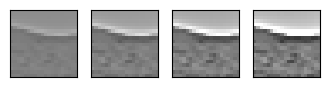

In [6]:
def plot_frame(frame, ax):
    ax.imshow(frame, vmin=-3.5, vmax=3.5, cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])

random.seed(42+2+13)
clip = fr_vs_contrast._dbs._val_dataset[123][0]
frame_c1 = torch.clamp(1 * clip, min=-3.5, max=3.5)
frame_c2 = torch.clamp(2 * clip, min=-3.5, max=3.5)
frame_c3 = torch.clamp(3 * clip, min=-3.5, max=3.5)
frame_c4 = torch.clamp(4 * clip, min=-3.5, max=3.5)

fig, ax = plt.subplots(1, 4, figsize=(4, 6))

plot_frame(frame_c1[0, 0], ax[0])
plot_frame(frame_c2[0, 0], ax[1])
plot_frame(frame_c3[0, 0], ax[2])
plot_frame(frame_c4[0, 0], ax[3])
plt.savefig(f"{root}/figures/fig4/contrast_frames.svg", format="svg", transparent=False, bbox_inches="tight")

### Contrast responses

In [7]:
def plot_contrast_response(c, healthy_response_fit, seizure_response_fit, healthy_sem_df, seizure_sem_df, ax):
    x_min, x_max = c.min(), c.max()+0.02
    y_min, y_max = 0, 0.07
    plot(y_lim=(y_min, y_max), x_lim=(x_min, x_max), x_label="Contrast", y_label="Firing rate (Hz)", ax=ax)
    sns.lineplot(healthy_sem_df, x="c", y="response", errorbar=("se", 1), marker="o", markersize=6, err_style="bars", linestyle="", err_kws={"capsize": 3}, c="black", ax=ax)
    sns.lineplot(seizure_sem_df, x="c", y="response", errorbar=("se", 1), marker="o", markersize=6, err_style="bars", linestyle="", err_kws={"capsize": 3}, c="deeppink", ax=ax)
    ax.plot(c, healthy_response_fit, c="black", linewidth=2.5)
    ax.plot(c, seizure_response_fit, c="deeppink", linewidth=2.5)
    ax.set_xticks([x_min, x_max])
    ax.set_xticklabels(["Min", "Max"])
    ax.set_yticks(np.linspace(0, 0.07, num=8))
    ytick_labels = ["" for _ in range(len(np.linspace(0, 0.07, num=8)))]
    ytick_labels[0] = 0
    ytick_labels[-1] = int(y_max * 120)
    ax.set_yticklabels(ytick_labels)
    
def plot_change_in_contrast_response(healthy_v, seizure_v, m, c, ax):
    x_min, x_max = 0, 0.1#+0.3
    y_min, y_max = x_min, x_max
    plot(y_lim=(y_min, y_max), x_lim=(x_min, x_max), x_label="Control model (spikes/s)", y_label="Seizure model (spikes/s)", ax=ax)
    
    mymkstyle = mks.MarkerStyle(marker=u"o", fillstyle=u"none")
    for i in range(len(healthy_v)):
        x1 = healthy_v[i][-1]
        y1 = m[i].item() * x1 + c[i].item()
        
        ax.plot([0, x1], [0, y1], c="gray", alpha=0.2, linewidth=0.2)
        ax.scatter(healthy_v[i], seizure_v[i], c="gray", alpha=0.1, marker=mymkstyle)
    
    ax.plot([0, 0.1], [0, m.mean().item() * 0.1 + c.mean().item()], c="deeppink", linewidth=4)
    ax.set_xticks([0, 0.033, 0.066, 0.1])
    ax.set_yticks([0, 0.033, 0.066, 0.1])
    ax.set_xticklabels([0, 4, 8, 12])
    ax.set_yticklabels([0, 4, 8, 12])

In [8]:
contrast_values = torch.logspace(start=-0.2, end=1, base=4, steps=8).numpy()
contrast_response_analysis = mechanisms.ContrastResponseAnalyses(root, model_id, contrast_values, decrease_gabba=0.8, seed=42)

In [9]:
contrast_values, healthy_response_fit, seizure_response_fit, healthy_sem_df, seizure_sem_df = contrast_response_analysis.get_contrast_response_data(-1) # 311
healthy_v, seizure_v = contrast_response_analysis.get_change_in_contrast_response_data()

/tmp/ipykernel_3840478/4113309851.py:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


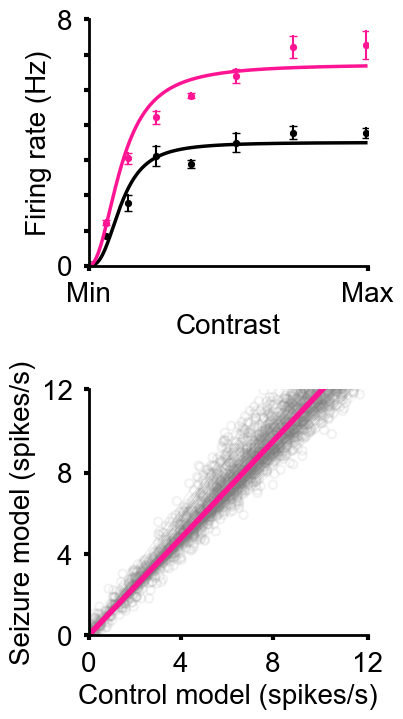

In [10]:
# fig, ax = plt.subplots(2, 1, figsize=(4.5, 8))
fig = plt.figure(figsize=(3.6, 8))
fig_spec = gridspec.GridSpec(2, 1, wspace=0., hspace=0.5)
ax1 = plt.subplot(fig_spec[0])
ax2 = plt.subplot(fig_spec[1])

plot_contrast_response(contrast_values, healthy_response_fit, seizure_response_fit, healthy_sem_df, seizure_sem_df, ax1) 
m, c = contrast_response_analysis.get_linear_fit_params()
plot_change_in_contrast_response(healthy_v, seizure_v, m, c, ax2)
fig.tight_layout()
plt.savefig(f"{root}/figures/fig4/contrast_responses.svg", format="svg", transparent=False, bbox_inches="tight")

In [11]:
contrast_response_analysis.print_linear_fit_params()

m=1.2258965969085693 c=-0.00349821918644011


In [12]:
contrast_response_analysis.print_m_stats()

t_stat=[36.73350552] p_value=[8.28376951e-126]


### Receptive fields

In [13]:
def plot_spatial_rfs(healthy_model_rfs, seizure_model_rfs, axs):
    # Load data
    hrf1, hrf2, hrf3 = healthy_model_rfs
    srf1, srf2, srf3 = seizure_model_rfs

    rf1_maxv = srf1.abs().max()
    rf2_maxv = srf2.abs().max()
    rf3_maxv = srf3.abs().max()
    
    axs[0, 0].imshow(hrf1, cmap="bwr", vmin=-rf1_maxv, vmax=rf1_maxv)
    axs[1, 0].imshow(hrf2, cmap="bwr", vmin=-rf2_maxv, vmax=rf2_maxv)
    axs[2, 0].imshow(hrf3, cmap="bwr", vmin=-rf3_maxv, vmax=rf3_maxv)

    axs[0, 1].imshow(srf1, cmap="bwr", vmin=-rf1_maxv, vmax=rf1_maxv)
    axs[1, 1].imshow(srf2, cmap="bwr", vmin=-rf2_maxv, vmax=rf2_maxv)
    axs[2, 1].imshow(srf3, cmap="bwr", vmin=-rf3_maxv, vmax=rf3_maxv)
    
    def nicify_frame(ax):
        ax.set_xticks([])
        ax.set_yticks([])
        edge_width = 1
        ax.spines["left"].set_linewidth(edge_width)
        ax.spines["right"].set_linewidth(edge_width)
        ax.spines["top"].set_linewidth(edge_width)
        ax.spines["bottom"].set_linewidth(edge_width)
        ax.set_aspect("auto")
        fig.add_subplot(ax)
    
    for i in range(3):
        for j in range(2):
            nicify_frame(axs[i, j])

    title_size = 16
    axs[0, 0].set_title("Control model", fontsize=title_size, pad=17)
    axs[0, 1].set_title("Seizure model", fontsize=title_size, pad=17)

In [14]:
rf_analyses = mechanisms.RFAnalyses(root, model_id, decrease_gabba=0.8)
healthy_model_rfs, seizure_model_rfs = rf_analyses.get_rfs([561, 252, 531])
healthy_model_rf_power, seizure_model_rf_power = rf_analyses.get_mean_power_per_spatial_rf()
print(f"Med control model RF power = {healthy_model_rf_power.median()}")
print(f"Med seizure model RF power = {seizure_model_rf_power.median()}")
print(f"RF CC={rf_analyses.get_cc_between_models_rfs([561, 252, 531])}")
U1, p = mannwhitneyu(healthy_model_rf_power, seizure_model_rf_power, alternative="less")
print(f"Power p-value={p}")

Med control model RF power = 0.3768479526042938
Med seizure model RF power = 0.3895183503627777
RF CC=tensor([0.9995, 0.9929, 0.9994])
Power p-value=0.0030600657812089637


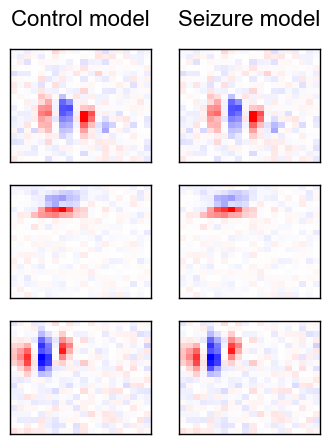

In [15]:
fig, axs = plt.subplots(3, 2, figsize=(4, 5))
plot_spatial_rfs(healthy_model_rfs, seizure_model_rfs, axs)
plt.savefig(f"{root}/figures/fig4/RFs.svg", format="svg", transparent=False, bbox_inches="tight")

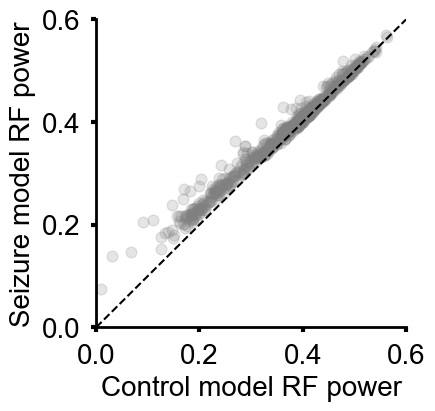

In [16]:
def plot_healthy_vs_seizure_model_RF_power(healthy_model_rf_power, seizure_model_rf_power, ax):
    x_min, x_max = 0, 0.6
    y_min, y_max = x_min, x_max
    plot(y_lim=(y_min, y_max), x_lim=(x_min, x_max), x_label="Control model RF power", y_label="Seizure model RF power", ax=ax)
    
    ax.scatter(healthy_model_rf_power, seizure_model_rf_power, c="gray", s=60, alpha=0.2)
    plt.plot([0, 0.6], [0, 0.6], linestyle="--", c="black")
    
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_healthy_vs_seizure_model_RF_power(healthy_model_rf_power, seizure_model_rf_power, ax)
plt.savefig(f"{root}/figures/fig4/RF_power.svg", format="svg", transparent=False, bbox_inches="tight")